<a href="https://colab.research.google.com/github/kschoi93/AI/blob/master/CNNTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

torch device가 cuda를 사용 할 수 있는지 확인을 하고 cuda or cpu 을 정합니다.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

datasets는 샘플과 정답을 저장하고 있습니다. 

ex) (image, label)

transforms를 통해 정규화를 합니다. datasets에서 넘어온 FashionMNIST 데이터셋은 PIL Image로 이루어져 있습니다. 

이를 Tensor 화 시킵니다.

In [3]:
train_dataset = torchvision.datasets.FashionMNIST(root='/', train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.FashionMNIST(root='/', train=False, download=True, transform=transforms.ToTensor())
print(train_dataset, test_dataset)
print(len(train_dataset[0]))
# plt.imshow(train_dataset[0][0])
print(train_dataset[0][0].shape)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /
    Split: Train
    StandardTransform
Transform: ToTensor() Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: /
    Split: Test
    StandardTransform
Transform: ToTensor()
2
torch.Size([1, 28, 28])


DataLoader는 dataset을 샘플에 쉽게 접근 할 수 있도록 순회 가능한 객체로 감쌉니다.

iterable = 순회 가능한 객체

In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)
print(train_loader, test_loader)

<torch.utils.data.dataloader.DataLoader object at 0x7f591ab81e50> <torch.utils.data.dataloader.DataLoader object at 0x7f591ab81dd0>


In [5]:
class FashionMNIST(nn.Module):
    def __init__(self):
        super(FashionMNIST, self).__init__()
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=28, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(in_features=2366*2*2*2, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
    
    def forward(self, x):
        out = self.conv2(x)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [6]:
model = FashionMNIST()
model.to(device)
print(model)

FashionMNIST(
  (conv2): Conv2d(1, 28, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=18928, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [7]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
print(model.parameters())

<generator object Module.parameters at 0x7f58124f4f50>


epoch: 0, count: 500, loss: 1.365533471107483
epoch: 1, count: 1000, loss: 0.913890540599823
epoch: 2, count: 1500, loss: 0.6797886490821838
epoch: 3, count: 2000, loss: 0.9297076463699341
epoch: 4, count: 2500, loss: 0.7108811736106873
epoch: 4, count: 3000, loss: 0.5792214870452881


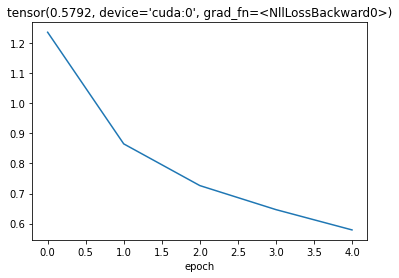

In [8]:
epochs = 5
count = 0
loss_ = []

for epoch in range(epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        train = images.view(100, 1, 28, 28)
        outputs = model(train)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1
        
        if not (count % 500):
            print("epoch: {}, count: {}, loss: {}".format(epoch, count, loss.data))
    loss_.append(loss.item())

plt.plot(loss_)
plt.title(loss)
plt.xlabel('epoch')
plt.show()

torch.Size([100, 1, 28, 28])
torch.Size([28, 28])
tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9,
        1, 4, 6, 0, 9, 3, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 3, 7, 6, 7, 2, 1,
        2, 2, 4, 4, 5, 8, 2, 2, 8, 4, 8, 0, 7, 7, 8, 5, 1, 1, 2, 3, 9, 8, 7, 0,
        2, 6, 2, 3, 1, 2, 8, 4, 1, 8, 5, 9, 5, 0, 3, 2, 0, 6, 5, 3, 6, 7, 1, 8,
        0, 1, 4, 2])


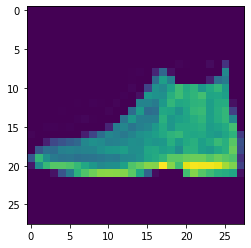

In [9]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
print(images.shape)
print(images[0][0].shape)
plt.imshow(images[0][0])
print(labels)

In [10]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum()

print(f'accuracy : {100*correct/total}%')

accuracy : 75.8699951171875%
